## The Escape Velocity as a Cosmological Probe: Theory

In 2012, [Nandra et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422.2945N/abstract) published research on the effect of an accelerating universe on a massive object. We start here.

Later that year, [Berhoozi et al. 2012](https://ui.adsabs.harvard.edu/abs/2013JCAP...06..019B/abstract) presented an expression for the radial and tangential escape speed from a cluster in this same context. Specifically, they provide the expression for a point source. Berhoozi introduced the term "equivalence radius" to define the point in space (relative to the center of a cluster) where the inward force of gravity (by the enclosed mass) balances the outward force created by the accelerated expansion of space-time:

$$r_{eq} = \sqrt[3]{\frac{GM}{-qH^2}} $$

where $H$ defines the expansion rate of the universe's scale factor: $\frac{\dot{a}}{a}$ and $q$ is the decelaration parameter, $q = -\frac{\ddot{a}{a}}{\dot{a}^2 } $. Note that the term $qH^2$ is then:

$$qH^2 = \frac{\ddot{a}}{a} = -\frac{4\pi G}{3} \sum_i \rho_i(1+3w_i)$$

where $w_i = p_i/(\rho_ic^2)$ and $p_i$, $\rho_i$ define the pressure and densities of the mass-energy components in the Friedmann equation. $w_i$ are the equations of state (0 for non-relativistic matter, 1/3 for radiation, and −1 for dark energy).

In 2016, our team began to take this theory into the obervational world. In [Miller et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/822/1/41) we established escape velocity in the context of typical Poisson pairs. The Poisson equation relates the density to the potential via: 

$$\nabla^2{\Psi(r)} = 4\pi G \rho(r)$$,

where $\Psi$ defines the total effective potential which includes both the gravitational component as well as the pther piece from the acceleration of space-time. In the weak field (i.e. Newtonian) limit, $v^2_{escape}(r) = -2\Psi(r)$:

$$v_{esc} = \sqrt{(-2\Phi(r) + 2\Phi(r_{eq}) - qH^2(r^2 - r_{eq}^2)}$$
where $\Phi$ is the gravitational-only part of the potential. The other terms incorporate the effect of an accelerating space-time through $qH^2$.

It is $v_{escape}$ which can be measured using data or simulations in order to infer the total potential $\Psi$. A key result from Miller et al. 2016 is that the escape velocity at $r_{eq}$ is zero by definition. This established the baseline of the observable escape velocity (in 3D) using the Millennium simulation data. The accuracy and precision of the observable to the theory is percent level.


Later that year, [Stark et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/830/2/109) established this technique as a true cosmological probe and the first results were reported on real data which direct comparisons (i.e., blind equivalent tests) to simulations.

In 2017, [Stark et al. 2017](https://ui.adsabs.harvard.edu/abs/2017PhRvD..96b3543S/abstract) built a Fisher Matrix formulism to make predictions on how well the escape velocity technique could constrain cosmological parameters.

### First, we import the needed libraries

In [1]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions_noastropy import *
from scipy.interpolate import interp1d
from scipy.stats import linregress

### We will be using Astropy's cosmology library as our base to define the models. 

Note that we will NOT use astropy cosmolgy objects in the MCMC analysis.

In [2]:
cosmo = FlatwCDM(H0=70, Om0=0.2,w0=-1)
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2)
cosmo = LambdaCDM(H0=70, Om0=0.2, Ode0 = 0)
cosmo = Flatw0waCDM(H0=70, Om0=0.2, w0=-0.9, wa=0.2)

Below are the cosmologies we can use. This function takes the name of the cosmology object that we have defined and then figures out how to return a new vector of the pertinent cosmological parameters. We will later feed this vector to the MCMC analysis (as opposed to a full astropy cosmology object).

In [3]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

Fun with numbers.

If you know some cosmology and have read the above theory preamble and/or references, none of the lines below should look foreign to you. If one does, please follow-up in the references.

In [4]:
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name='FlatLambdaCDM')
cosmo_params = cosmology(cosmo)
z=0.2
M200 = 1e15*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print 'Astropys critical density: ', rho_crit
print 'Internal critical density: ',rho_crit_z(z,cosmo_params,'FlatLambdaCDM')
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
print 'Spherical R200 for a given M200: ', R200crit
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
print 'Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name
print 'q = ', q_z_function(z, cosmo_params,cosmo.name)
print 'r_eq = ', r_eq(0.2,M200,cosmo_params, cosmo.name)

Astropys critical density:  1.55793520483e+11 solMass / Mpc3
Internal critical density:  1.55793520483e+11 solMass / Mpc3
Spherical R200 for a given M200:  1.97141172229 Mpc
Gravity (Mpc km2/s^2 kg), mass, cosmology:  4.30091727007e-09 1e+15 solMass [0.2, 0.7] FlatLambdaCDM
q =  -0.547486033519553
r_eq =  11.1854377804 Mpc


Next, we define an escape velocity profile in a Flat $\Lambda$CDM Universe. We start with a chosen $M_{200}$. We call a cosmology object. We set the cosmologic parameters. We define a set of radial bins in physical coordinates (i.e., Mpc). We choose a redshift. We then convert those physical coordinates to angles on the sky.

We then call the function einasto_nfwM200_errors from the library. This function use a mass concentration relation and spherical symmetry to determine the einasto parameters which also fit this same escape velocity profile. If there is error (the second parameter), than a $\chi^2$ analysis is performed and errors on those parameters are returned.

The following block of code creates a single cluster with a specified M200, redshift, and its Einasto parameters for a flat LCDM cosmology with $\Omega_m = 0.2$ and $\Omega_{DE} = 0.8$. Given a fixed (to the local frame) physical set of radial bins, we then calculate the escape velocity profile given the observed radial profile on the sky. We use an NFW and and EINasto profile.

In [5]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.2,Ode0 = 0.8, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z,cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n,c)
rho_0 = np.resize(rho_0,(1,len(z)))
h = np.resize(h,(1,len(z)))
n = np.resize(n, (1,len(z)))
print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_flatLCDM = rho_0
h_Om02Ode08_LCDM = h
n_Om02Ode08_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om02Ode08_EIN,vesc_Om02Ode08_EIN = v_esc_einasto(xdata,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_Om02Ode08_NFW,vesc_Om02Ode08_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

Einasto rho_0, h, and n parameters:  [[4.95983676e+17]] [[0.00015284]] [[3.93512083]]


escape_functions_noastropy.py:737: RuntimeWarning: invalid value encountered in power
  return rho_0*np.exp(-(r/h)**(1./n))


Let us try a flat LCDM cosmology with $\Omega_m = 0.3$ and $\Omega_{DE} = 0.7$

In [6]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.3,Ode0 = 0.7, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z,cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n,c)
rho_0 = np.resize(rho_0,(1,len(z)))
h = np.resize(h,(1,len(z)))
n = np.resize(n, (1,len(z)))
print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_flatLCDM = rho_0
h_Om02Ode08_LCDM = h
n_Om02Ode08_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om03Ode07_EIN,vesc_Om03Ode07_EIN = v_esc_einasto(xdata,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_Om03Ode07_NFW,vesc_Om03Ode07_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

Einasto rho_0, h, and n parameters:  [[5.23666004e+17]] [[0.0001516]] [[3.93088349]]


Next, we do the same except we set dark energy to zero: $\Omega_m = 0.2$ and $\Omega_{DE} = 0$

In [7]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.2,Ode0 = 0.0, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z,cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n,c)
rho_0 = np.resize(rho_0,(1,len(z)))
h = np.resize(h,(1,len(z)))
n = np.resize(n, (1,len(z)))
print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_Om02_LCDM = rho_0
h_Om02_LCDM = h
n_Om02_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om02_EIN,vesc_Om02_EIN = v_esc_einasto(xdata,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_Om02_NFW,vesc_Om02_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

Einasto rho_0, h, and n parameters:  [[6.30915918e+17]] [[0.00014639]] [[3.9193569]]


We now plot the radial profiles and evaluate:

[0.1   0.367 0.633 0.9   1.167 1.433 1.7   1.967 2.233 2.5  ] [2822.13635899 2494.27094008 2256.54900631 2069.43758687 1915.6980967
 1785.81623324 1672.76103517 1573.06931874 1484.29103042 1403.76487492]
[0.1   0.367 0.633 0.9   1.167 1.433 1.7   1.967 2.233 2.5  ] [3110.68237394 2769.07746108 2529.6910958  2346.0284254  2198.47172902
 2076.37252571 1972.17017018 1882.02779623 1803.23959846 1733.0768228 ]


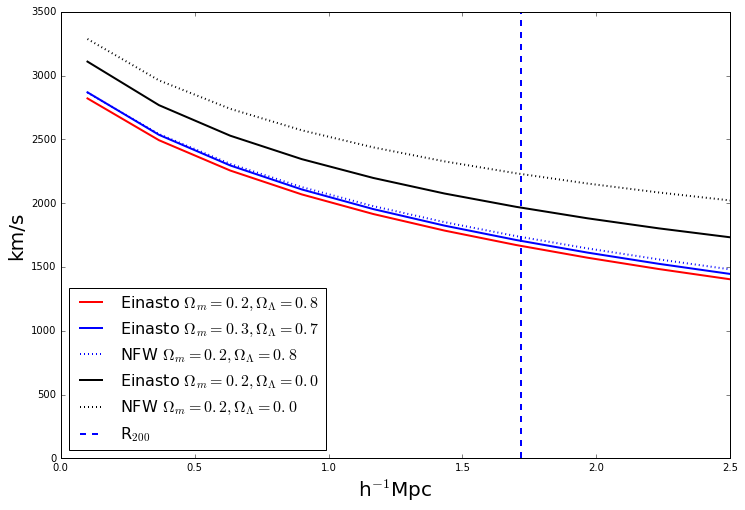

In [30]:
print r_Om02Ode08_EIN[0], vesc_Om02Ode08_EIN[0]
print r_Om02_EIN[0],vesc_Om02_EIN[0]
fig = plt.figure(figsize=(12, 8))
plt.plot(r_Om02Ode08_EIN[0],vesc_Om02Ode08_EIN[0],'r-',lw=2, label ='Einasto $\Omega_m = 0.2, \Omega_{\Lambda}=0.8$')
plt.plot(r_Om03Ode07_EIN[0],vesc_Om03Ode07_EIN[0],'b-',lw=2, label ='Einasto $\Omega_m = 0.3, \Omega_{\Lambda}=0.7$')
plt.plot(r_Om02Ode08_NFW[0],vesc_Om02Ode08_NFW[0],'b:',lw=2, label ='NFW $\Omega_m = 0.2, \Omega_{\Lambda}=0.8$')
plt.plot(r_Om02_EIN[0],vesc_Om02_EIN[0],'k-',lw=2, label = 'Einasto $\Omega_m = 0.2, \Omega_{\Lambda}=0.0$')
plt.plot(r_Om02_NFW[0],vesc_Om02_NFW[0],'k:',lw=2, label ='NFW $\Omega_m = 0.2, \Omega_{\Lambda}=0.0$')
plt.axvline(R200.value, linestyle='--',lw=2,label = r'R$_{200}$')
plt.legend(loc=3,fontsize=16)
plt.ylim(0,3500)
plt.xlabel(r'h$^{-1}$Mpc',size=20)
plt.ylabel('km/s',size=20)
plt.show()

First: In the above plot, we see that by including a non-zero $\Lambda$ term in the cosmology, this cluster phase-space is affected quite dramatically by dark energy (red versus black). $\Lambda$ suppresses the escape-edge, regardless of the analytical representation of the density/potential profile. This is the inuitively expected result, since galaxies are accelerating beyond their gravity-only escape velocities due to the accelerated expansion of space-time. These galaxies then leave the system, never to return.

Second: We see that when $\Lambda$ is non-zero, there is very little difference in the escape velocity profile between the two density/potential analytical forms.

If one examines the second point further, you will find that the Poisson-Pair form differences drop below 50km/s at a value of $\Omega_{\Lambda} = 0.6$, where 50km/s is about the typical instrumental calibration error (i.e., accuracy) of a mediam resolution spectrograph (R $\sim$ 1000).

In other words, for a $\Lambda$ dominated universe, it will be difficult to see a difference in the potental profile given the known differences between the NFW and the Einasto formula with today's modern multiplexed spectroscopic instruments.

Put another way, if we solve for (or use) a specific value for $\Omega_{\Lambda}$ , we would have to include a systematic uncertainty on the escape profile that is caused by the shape differences betweem the Einasto and NFW. For a cluster with $M_{200}$ = 1e15 at z = 0.2, this amounts to about a percent additional systematic error in the intepretation of the observed edge as the true 2D projected escape velocity profile.

In [21]:
print np.mean((np.array(vesc_Om02Ode08_NFW) - np.array(vesc_Om02Ode08_EIN)))

62.76746675870336


In the above analysis, we looked at the profile of a single cluster at different radii. However, the profile itself also evolves with redshift as a function of cosmology. 

Let us also look at the evolution of the profile at a few radii as a function of redshift.

To make things simple, we will use a cluster described by a single M200, but at different redshifts. Because the critical density evolves with redshift, we expect to see different shape profiles as a function of redshift. For a fixed mass and an increasing critical density with redshift, $R_{200}$ goes down with redshift.

For this scenario, we are going to use the vectorization of the escape velocity function. We will specify a range or redshifts, which will result in a range (of the same size vector) of shape parameters. We will use the same $N_{gal}= 100$ for each of the clusters.

For this vectorized example, we will return arrays of radii and escape velocity profile, one for each "cluster" at each redshift.

First, we create our sample of 79 clusters (see redshift binning) for our fidcucial cosmology:  $\Omega_m = 0.2$ and $\Omega_{DE} = 0.0$

In [22]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.2,Ode0=0.0,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z= np.arange(0.01, 1.0, 0.01)
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z[i],cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n, c)
#print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_Om02Ode00_LCDM = rho_0
h_Om02Ode00_LCDM = h
n_Om02Ode00_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,4.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om02Ode00_LCDM_EIN,vesc_Om02Ode00_LCDM_EIN = v_esc_einasto(xdata,z,rho_0_Om02Ode00_LCDM,h_Om02Ode00_LCDM,n_Om02Ode00_LCDM,N,cosmo_params, cosmo_name,num_clus)
r_Om02Ode00_LCDM_NFW,vesc_Om02Ode00_LCDM_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name,num_clus)

Now we change the cosmology to something Planck-like:  $\Omega_m = 0.3$ and $\Omega_{DE} = 0.7$

In [23]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.3,Ode0=0.7,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z= np.arange(0.01, 1.0, 0.01)
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z[i],cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n, c)
#print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_Om03Ode07_LCDM = rho_0
h_Om03Ode07_LCDM = h
n_Om03Ode07_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,4.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om03Ode07_LCDM_EIN,vesc_Om03Ode07_LCDM_EIN = v_esc_einasto(xdata,z,rho_0_Om03Ode07_LCDM,h_Om03Ode07_LCDM,n_Om03Ode07_LCDM,N,cosmo_params, cosmo_name,num_clus)
r_Om03Ode07_LCDM_NFW,vesc_Om03Ode07_LCDM_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name,num_clus)

Finally a drastic change:  $\Omega_m = 1.0$ and $\Omega_{DE} = 0.0$

In [24]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=1.0,Ode0=0.0,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z= np.arange(0.01, 1.0, 0.01)
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z[i],cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n, c)
#print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_Om10Ode00_LCDM = rho_0
h_Om10Ode00_LCDM = h
n_Om10Ode00_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,4.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om10Ode00_LCDM_EIN,vesc_Om10Ode00_LCDM_EIN = v_esc_einasto(xdata,z,rho_0_Om10Ode00_LCDM,h_Om10Ode00_LCDM,n_Om10Ode00_LCDM,N,cosmo_params, cosmo_name,num_clus)
r_Om10Ode00_LCDM_NFW,vesc_Om10Ode00_LCDM_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name,num_clus)

Recall that we now have 79 clusters and three escapr velocity profiles for each at three different comologies. 

We will first plot the difference in the escape profiles compared to our fiducial $\Omega_m = 0.2$ and $\Omega_{DE} = 0.8$ at z = 0.2:

In [28]:
i = 19
fig = plt.figure(figsize=(12, 8))
plt.plot(r_Om02Ode00_LCDM_EIN[i,:],(vesc_Om02Ode00_LCDM_EIN[i,:]-vesc_Om02Ode00_LCDM_EIN[i,:])/vesc_Om02Ode00_LCDM_EIN[i,:]*1.0,'k',lw=2,label=r'$\Omega_m=0.2, \Omega_{\Lambda}$=0.0')
plt.plot(r_Om03Ode07_LCDM_EIN[i,:],(vesc_Om03Ode07_LCDM_EIN[i,:]-vesc_Om02Ode00_LCDM_EIN[i,:])/vesc_Om02Ode00_LCDM_EIN[i,:]*1.0,'b',lw=2,label=r'$\Omega_m=0.3, \Omega_{\Lambda}$=0.7')
plt.plot(r_Om10Ode00_LCDM_EIN[i,:],(vesc_Om10Ode00_LCDM_EIN[i,:]-vesc_Om02Ode00_LCDM_EIN[i,:])/vesc_Om02Ode00_LCDM_EIN[i,:]*1.0,'r',lw=2,label='$\Omega_m=1.0, \Omega_{\Lambda}$=0.0')
plt.legend(loc=0)
plt.xlim(0.3,2.5)
plt.ylim(-0.5,0.5)
plt.ylabel(r'$\frac{\rm{v}_{esc}-\rm{v}_{esc}^{\Lambda = 0}}{\rm{v}_{esc}^{\Lambda = 0}}$',fontsize=24)
plt.xlabel('r (Mpc)', fontsize=20)
plt.title(r'Galaxy cluster $v_{escape}$ profile',fontsize=24)
M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, 0.2,cosmo_params, cosmo_name)
plt.axvline(R200.value)
plt.show()
print 'At z = ', z[i], r' where R_200 = ', R200.value, 'Mpc'

At z =  0.2  where R_200 =  1.7189916095 Mpc


Next we plot the difference in the escape profile measured near the virial radius as a function of redshift as compared to our fiducial $\Omega_m = 0.2$ and $\Omega_{DE} = 0.8$ at :

In [41]:
i = 4
fig = plt.figure(figsize=(12, 8))
plt.plot(z,(vesc_Om02Ode00_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'k',lw=2,label=r'$\Omega_m=0.2, \Omega_{\Lambda}$=0.0')
plt.plot(z,(vesc_Om03Ode07_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'b',lw=2,label=r'$\Omega_m=0.3, \Omega_{\Lambda}$=0.7')
plt.plot(z,(vesc_Om10Ode00_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'r',lw=2,label='$\Omega_m=1.0, \Omega_{\Lambda}$=0.0')

#plt.plot(z,(vesc_Om02Ode08_EIN[:,i]-vesc_Om02Ode08_EIN[:,i])/vesc_Om02Ode08_EIN[:,i]*1.0,'r',label=r'$\Omega_m=0.2, \Omega_{\Lambda}$=0.8')
#plt.plot(z,(vesc_Om03Ode07_EIN[:,i]-vesc_Om02Ode08_EIN[:,i])/vesc_Om02Ode08_EIN[:,i]*1.0,'b',label=r'$\Omega_m=0.3, \Omega_{\Lambda}$=0.7')
#plt.plot(z,(vesc_Om02_EIN[:,i]-vesc_Om02Ode08_EIN[:,i])/vesc_Om02Ode08_EIN[:,i]*1.0,'k',label='$\Omega_m=02, \Omega_{\Lambda}$=0.0')
plt.xlim(0, 1)
plt.ylim(-0.6,0.5)
plt.ylabel(r'$\frac{\rm{v}_{esc}-\rm{v}_{esc}^{\Lambda = 0}}{\rm{v}_{esc}^{\Lambda = 0}}$',fontsize=24)
plt.xlabel('z ', fontsize=20)
plt.title(r'Galaxy cluster $v_{escape}$ z evolution',fontsize=20)
print 'At r = ', r_Om03Ode07_LCDM_EIN[0,i],'Mpc'
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.3,Ode0 = 0.7, name = cosmo_name)
cosmo_params = cosmology(cosmo)
plt.axvline(z_trans(cosmo_params, cosmo_name),ls='--',label=r'$\Lambda$ Transition')
plt.legend(loc=0)
plt.show()

At r =  1.833 Mpc


In the redshit evolution, there is a feature at te transition redshift where $r_{eq}$ becomes infinite. It is at this point where cluster escape profiles transition to being affected by the acceleration (as opposed ti just defined by the gravitational potential. We can see that beyond this redshiftm the differences track a non-accelerating Universe, as expected. 

The time elapsed between z = 0.7 and z = 0.65 around this transition is about 300 million years. Galaxies moving at an escape speed around 2000km/s can travel as far as 6Mpc in this time, thus escaping the phase-space. It will be interesting to see if this transition is detectable in simulations.

Lets re-make the plot except we can add the age of the Universe at the top of the x-axis:

In [42]:
i = 4
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z,(vesc_Om02Ode00_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'k',lw=2,label=r'$\Omega_m=0.2, \Omega_{\Lambda}$=0.0')
ax1.plot(z,(vesc_Om03Ode07_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'b',lw=2,label=r'$\Omega_m=0.3, \Omega_{\Lambda}$=0.7')
ax1.plot(z,(vesc_Om10Ode00_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'r',lw=2,label='$\Omega_m=1.0, \Omega_{\Lambda}$=0.0')
ax1.axvline(z_trans(cosmo_params, cosmo_name), ls='--',label = r'$\Lambda$ Transition')
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel(r'$\frac{\rm{v}_{esc}-\rm{v}_{esc}^{\Lambda = 0}}{\rm{v}_{esc}^{\Lambda = 0}}$',fontsize=24)
ax1.set_xlabel('z ', fontsize=20)
title = ax1.set_title(r'Galaxy cluster $v_{escape}$ z evolution',fontsize=20)
title.set_y(1.2)
ax2 = ax1.twiny()
ax1Xs = ax1.get_xticks()
ax2Xs = cosmo.age(ax1Xs)
ax2.set_xticks(ax1Xs)
ax2.set_xbound(ax1.get_xbound())
ax2Xs_form = ['%1.2f' % tick for tick in ax2Xs.value]
ax2.set_xticklabels(ax2Xs_form)
ax2.set_xlabel('Gyr ', fontsize=20)
ax2.get_yaxis().set_visible(False)
ax1.legend(loc=0)
fig.show()

print 'At r = ', r_Om03Ode07_LCDM_EIN[0,i],'Mpc'
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.3,Ode0 = 0.7, name = cosmo_name)
cosmo_params = cosmology(cosmo)


At r =  1.833 Mpc


As a comparison, here is what we would expect for a Type 1a supernovae cosmological analysis: 

In [44]:
z = np.arange(0,1.0,0.01)
Omega_M_fid = 0.2
H0 = 70
cosmo = LambdaCDM(H0=70, Om0=Omega_M_fid, Ode0 = 0.0)
lumd0 = cosmo.luminosity_distance(z)
fig = plt.figure(figsize=(12, 8))
plt.plot(z, 5*np.log10(lumd0.value/lumd0.value),'k',lw=2,label = r'$\Omega_m$=0.2, $\Omega_{\Lambda}$=0.0')
Omega_M_fid = 0.3
cosmo = LambdaCDM(H0=70, Om0=Omega_M_fid, Ode0 = 0.7)
lumd = cosmo.luminosity_distance(z)
plt.plot(z, 5*np.log10(lumd.value/lumd0.value),'b',lw=2,label = r'$\Omega_m$=0.3,  $\Omega_{\Lambda}$=0.7')
Omega_M_fid = 1.0
cosmo = LambdaCDM(H0=70, Om0=Omega_M_fid, Ode0 = 0.0)
lumd = cosmo.luminosity_distance(z)
plt.plot(z, 5*np.log10(lumd.value/lumd0.value),'r',lw=2, label = r'$\Omega_m$=1.0, $\Omega_{\Lambda}$=0.0')
plt.legend(loc=3)
plt.ylabel(r'$\Delta$(m-M) (mag)',fontsize=22)
plt.xlabel('redshift z', fontsize=20)
plt.xlim(0,1.0)
plt.ylim(-0.5,0.5)
plt.title("Type 1a supernovae",fontsize=20)
plt.show()

/u/home/christoq/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/u/home/christoq/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/u/home/christoq/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


And here is the figure from [Kirschner 1999](https://doi.org/10.1073/pnas.96.8.4224):

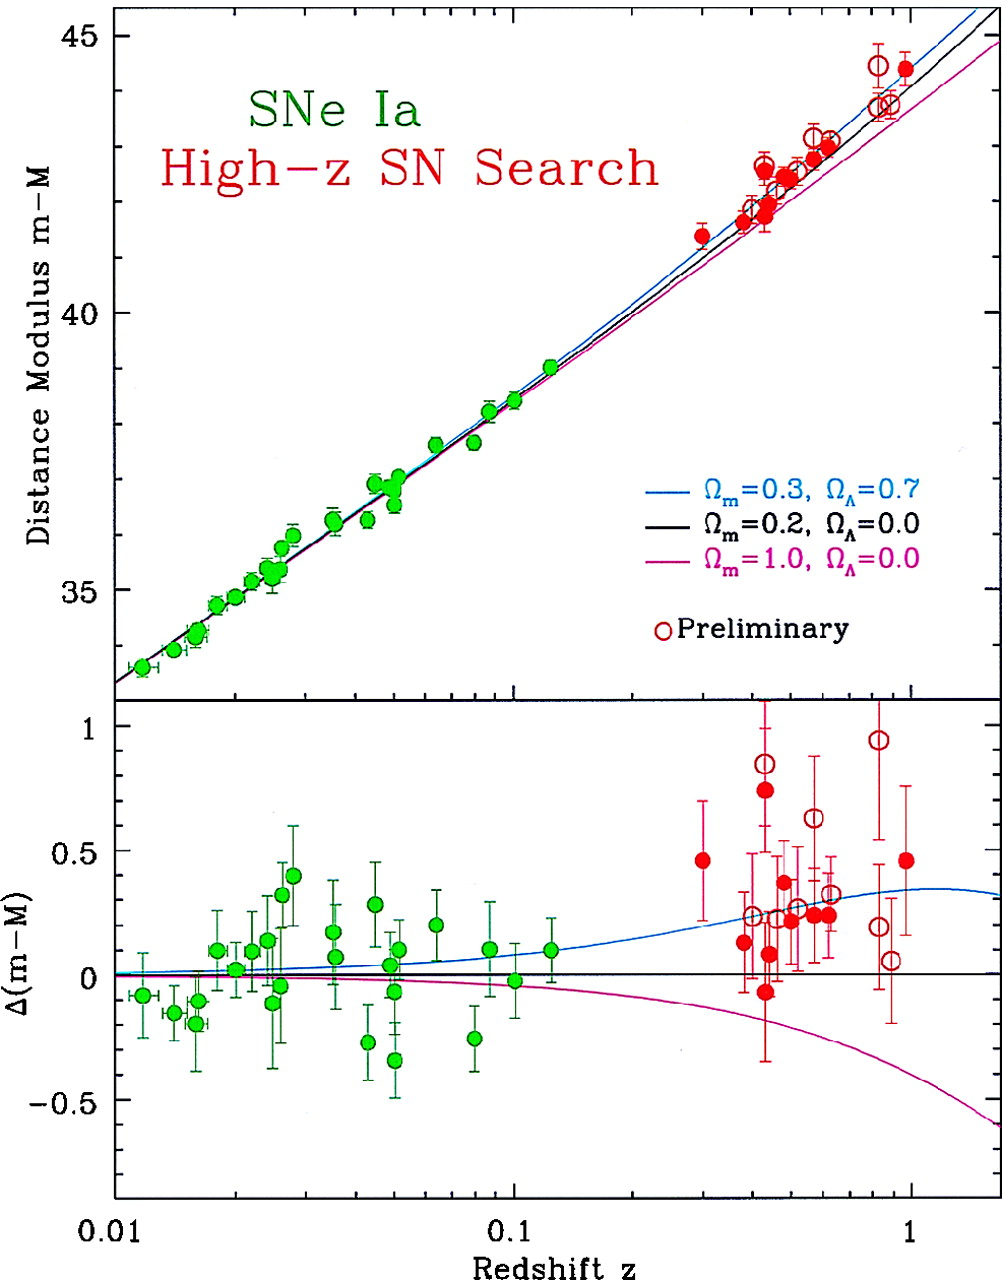

In [245]:
Image(filename='F3.large.jpg') 

/u/home/christoq/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide


At z =  0.19  where R_200 =  1.93133838816 Mpc


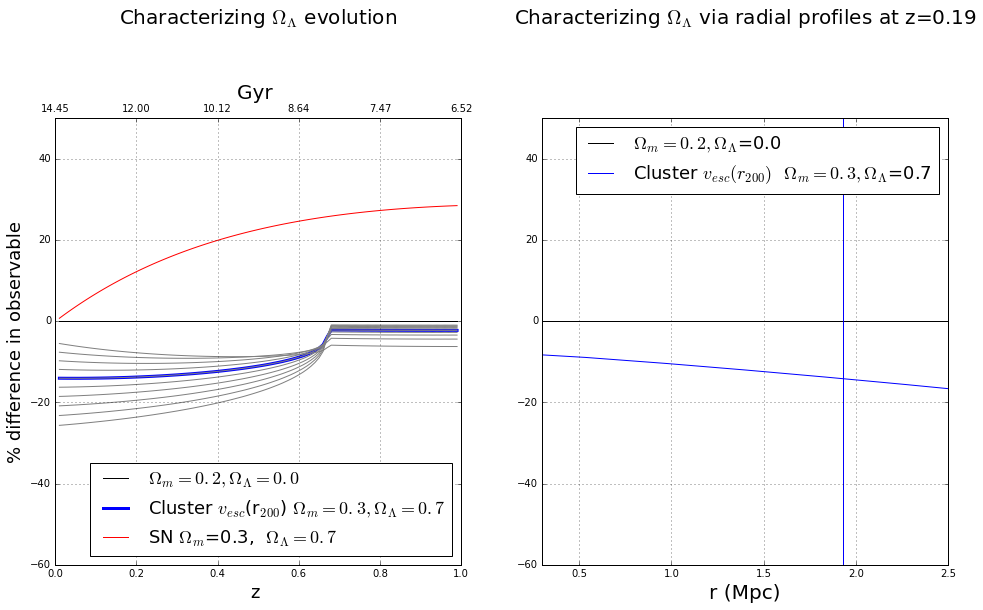

In [51]:
z= np.arange(0.01, 1.0, 0.01)
i = 4
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.plot(z,100*(vesc_Om02Ode00_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'k',label=r'$\Omega_m=0.2, \Omega_{\Lambda}=0.0$')
ax1.plot(z,100*(vesc_Om03Ode07_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'b',lw=3,label=r'Cluster $v_{esc}$(r$_{200}$) $\Omega_m=0.3, \Omega_{\Lambda}=0.7$')
for i in range(radial_bins):
    ax1.plot(z,100*(vesc_Om03Ode07_LCDM_EIN[:,i]-vesc_Om02Ode00_LCDM_EIN[:,i])/vesc_Om02Ode00_LCDM_EIN[:,i]*1.0,'grey')
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(-60,50)
ax1.set_ylabel(r'% difference in observable',fontsize=18)
ax1.set_xlabel('z ', fontsize=18)
title = ax1.set_title(r'Characterizing $\Omega_{\Lambda}$ evolution',fontsize=20)
title.set_y(1.2)
ax2 = ax1.twiny()
ax1Xs = ax1.get_xticks()
ax2Xs = cosmo.age(ax1Xs)
ax2.set_xticks(ax1Xs)
ax2.set_xbound(ax1.get_xbound())
ax2Xs_form = ['%1.2f' % tick for tick in ax2Xs.value]
ax2.set_xticklabels(ax2Xs_form)
ax2.set_xlabel('Gyr ', fontsize=20)
ax2.get_yaxis().set_visible(False)
z = np.arange(0,1.0,0.01)
Omega_M_fid = 0.2
H0 = 70
cosmo = LambdaCDM(H0=70, Om0=Omega_M_fid, Ode0 = 0.0)
lumd0 = cosmo.luminosity_distance(z)
cosmo = LambdaCDM(H0=70, Om0=Omega_M_fid, Ode0 = 0.7)
lumd = cosmo.luminosity_distance(z)
ax1.plot(z, 100*5*np.log10(lumd.value/lumd0.value),'r',label = r'SN $\Omega_m$=0.3,  $\Omega_{\Lambda}=0.7$')
ax1.legend(loc=4,fontsize=18)

ax3 = fig.add_subplot(122)
i = 19
ax3.plot(r_Om02Ode00_LCDM_EIN[i],100*(vesc_Om02Ode00_LCDM_EIN[i]-vesc_Om02Ode00_LCDM_EIN[i])/vesc_Om02Ode00_LCDM_EIN[i]*1.0,'k',label=r'$\Omega_m=0.2, \Omega_{\Lambda}$=0.0')
ax3.plot(r_Om03Ode07_LCDM_EIN[i],100*(vesc_Om03Ode07_LCDM_EIN[i]-vesc_Om02Ode00_LCDM_EIN[i])/vesc_Om02Ode00_LCDM_EIN[i]*1.0,'b',label=r'Cluster $v_{esc}(r_{200})$  $\Omega_m=0.3, \Omega_{\Lambda}$=0.7')
ax3.grid(True)
ax3.legend(loc=0,fontsize=18)
ax3.set_xlim(0.3,2.5)
ax3.set_ylim(-60,50)
ax3.set_xlabel('r (Mpc)', fontsize=20)
title = ax3.set_title(r'Characterizing $\Omega_{\Lambda}$ via radial profiles at z=0.19',fontsize=20)
title.set_y(1.2)
M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, 0.2,cosmo_params, cosmo_name)
ax3.axvline(R200.value)
print 'At z = ', z[i], r' where R_200 = ', R200.value, 'Mpc'

fig.show()

In [15]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.05))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(5e14*u.solMass,len(z))
M200_use = np.repeat(5e14,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

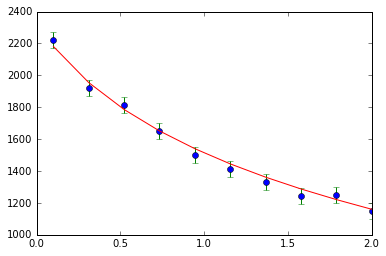

In [16]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [17]:
def lnprior(theta):
    p_M200 = theta[0]
    if not(1e13 < p_M200 < 1e17 ):
          return -np.inf
    return 0.0

In [18]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = np.repeat(theta[0],len(p_z))
    p_N = N
    p_num_clus = num_clus
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    ymodel_fixed = lambda p_theta_array,p_M200:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_M200)
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [19]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [20]:
ndim, nwalkers, nsteps = 1, 50, 1000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13])#print np.shape(p0)

In [21]:
pool = Pool(processes=30)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

escape_functions_noastropy.py:129: RuntimeWarning: invalid value encountered in double_scalars
  r200 =   (3*M200[i]/(4*np.pi*200*rho_crit))**(1/3.0)
escape_functions_noastropy.py:432: RuntimeWarning: invalid value encountered in double_scalars
  c200 = A * (mass/Mpivot)**B * (1+redshift)**C
escape_functions_noastropy.py:129: RuntimeWarning: invalid value encountered in double_scalars
  r200 =   (3*M200[i]/(4*np.pi*200*rho_crit))**(1/3.0)
escape_functions_noastropy.py:432: RuntimeWarning: invalid value encountered in double_scalars
  c200 = A * (mass/Mpivot)**B * (1+redshift)**C
/u/home/christoq/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in power
  *arrays, **kwargs)
/u/home/christoq/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in power
  *arrays, **kwargs)
escape_functions_noastropy.py:129: RuntimeWarning: invalid value encountered in double_scalars
  r20

State([[4.92682774e+14]
 [4.64409200e+14]
 [4.72559081e+14]
 [4.93253943e+14]
 [5.01745951e+14]
 [4.79888484e+14]
 [4.93018057e+14]
 [4.75831675e+14]
 [4.94889367e+14]
 [4.84771754e+14]
 [5.03226066e+14]
 [5.16666404e+14]
 [4.90768413e+14]
 [4.98633311e+14]
 [5.07020778e+14]
 [5.06960736e+14]
 [4.84156175e+14]
 [4.94348230e+14]
 [4.88660550e+14]
 [4.96234317e+14]
 [4.88740364e+14]
 [4.82650593e+14]
 [5.08222126e+14]
 [4.99874898e+14]
 [4.84052262e+14]
 [4.89449722e+14]
 [4.95826865e+14]
 [5.16197442e+14]
 [4.92095991e+14]
 [4.85709878e+14]
 [4.98973043e+14]
 [5.25582341e+14]
 [4.96446805e+14]
 [4.77402103e+14]
 [4.86183457e+14]
 [4.92486012e+14]
 [5.08011846e+14]
 [4.76916485e+14]
 [5.04728271e+14]
 [5.11958085e+14]
 [4.74129957e+14]
 [4.93913336e+14]
 [4.84533959e+14]
 [4.81274876e+14]
 [4.57978741e+14]
 [4.98666331e+14]
 [4.90354998e+14]
 [4.87165465e+14]
 [4.97305114e+14]
 [4.96370177e+14]], log_prob=[-1.86771728 -5.09440917 -3.52766751 -1.86479842 -2.09861709 -2.56639542
 -1.865715

In [22]:
burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print np.shape(sampler.chain)
fig = corner.corner(samples[:,:], labels=["M200"], truths = [M200_use])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print 'median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33
print 'median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33)
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print 'Truth: ', np.log10(M200_use)

(50, 1000, 1)


67
median(M200) =  493947580522796.7 +/- 11995329575406.625 11123597675171.125
median(logM200) =  14.6936808624912 +/- 0.010420651921482005 0.009892028241329953
Truth:  [14.69897]


In [23]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(5e14*u.solMass,len(z))
M200_use = np.repeat(5e14,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

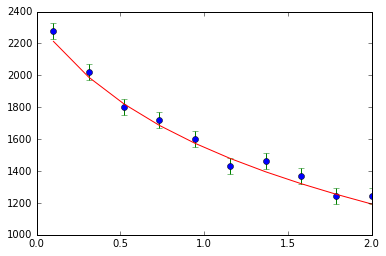

In [46]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [25]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1)):
          return -np.inf
    return 0.0

In [26]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_rho_s= np.repeat(theta[0],(1))
    p_r_s = np.repeat(theta[1],(1))
    p_N = N
    p_num_clus = num_clus
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    ymodel_fixed = lambda p_theta_array,p_rho_s, p_r_s:v_esc_NFWs(p_theta_array,p_z, p_rho_s, p_r_s,N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_rho_s, p_r_s)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [27]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [28]:
ndim, nwalkers, nsteps = 2, 50, 1000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers)])

In [29]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

escape_functions_noastropy.py:254: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  rho_r = np.append(rho_r,4*np.pi*integrate.quad(rhos_nfw_int,0,r[j],args=(rho_s[i],r_s[i]))[0]/(4/3.*np.pi*(r[j]**3.0)))
/u/home/christoq/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in power
  *arrays, **kwargs)
escape_functions_noastropy.py:254: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  rho_r = np.append(rho_r,4*np.pi*integrate.quad(rhos_nfw_int,0,r[j],args=(rho_s[i],r_s[i]))[0]/(4/3.*np.pi*(r[j]**3.0)))
escape_functions_noastropy.py:267: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_nfw(r,rho_s,r_s) +2*phi_nfw(req,rho_s,r_s)-q_z*(H_z**2.)*(r**2 - req**2) )**0.5
/u

State([[5.56018808e+14 4.69077616e-01]
 [4.77388018e+14 5.12379363e-01]
 [4.42533434e+14 5.16291705e-01]
 [2.51979806e+14 6.77605106e-01]
 [2.39446738e+15 2.53144899e-01]
 [3.57550279e+14 5.90832474e-01]
 [3.38050638e+14 6.00185183e-01]
 [2.49103737e+14 6.84264799e-01]
 [4.76141208e+14 5.07421209e-01]
 [1.80445648e+14 8.02357785e-01]
 [3.51943971e+14 5.82537923e-01]
 [6.23307409e+14 4.53675796e-01]
 [4.66350502e+14 5.14800311e-01]
 [4.34029822e+14 5.29702079e-01]
 [2.66733056e+14 6.61232140e-01]
 [5.64980144e+14 4.75231527e-01]
 [5.54885629e+14 4.75500287e-01]
 [2.57489865e+14 6.74448863e-01]
 [4.23150480e+14 5.37131364e-01]
 [2.86131388e+14 6.47595623e-01]
 [3.68320751e+14 5.69866182e-01]
 [2.54520746e+14 6.73326634e-01]
 [4.12519504e+14 5.39267693e-01]
 [4.96052054e+14 4.96359372e-01]
 [2.34702816e+14 7.01441332e-01]
 [4.54030303e+14 5.23822755e-01]
 [3.58118660e+14 5.79524678e-01]
 [2.95970812e+14 6.32968287e-01]
 [4.79844950e+14 4.97785815e-01]
 [6.16472513e+14 4.50046731e-01]
 [5.

574517057947950.9 0.46071067596929743 [0.2]
(50, 1000, 2)


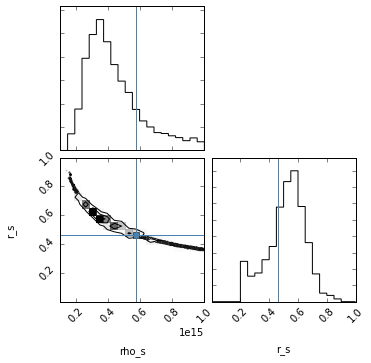

median(rho_s) =  424910971175659.75 +/- 464056266983150.75 135306612336378.12
median(log rho_s) =  14.628297944691623 +/- 0.32058781116157675 0.16649285054496055
Truth:  14.759302927824459
median(r_s) =  0.5347997009071832 +/- 0.10503359146012936 0.1507340304294218
Truth:  0.46071067596929743


In [40]:
M200_true,R200_true,conc_true,rho_s_true, sigma_rho_s_true,r_s_true, sigma_r_s_true =  nfws_errors(M200_orig[0], 0.2, z[0],cosmo_params, cosmo.name)
print rho_s_true, r_s_true, z
burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 2))
print np.shape(sampler.chain)
fig = corner.corner(samples[:,:], labels=["rho_s", "r_s"], truths = [rho_s_true, r_s_true], range=[(1e14,1e15), (0.0,1.0)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print 'median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33
print 'median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33)
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print 'Truth: ', np.log10(rho_s_true)
print 'median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print 'Truth: ',r_s_true

In [55]:
burn = 100
len_r = radial_bins
len_r_interp = 1000
rho_crit = cosmo.critical_density(z[0])
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
rho_s_fitted = sampler.chain[:,burn:,0].flatten()
r_s_fitted = sampler.chain[:,burn:,1].flatten()
rand_vec = np.random.uniform(1,len(r_s_fitted),size=10000).astype(int)
r_denfit = np.linspace(np.min(r),np.max(r),len_r).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
r_interp = np.linspace(np.min(r),np.max(r),len_r_interp).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.     
M200_fitted = []
R200_fitted = []
for k in range(num_clus):
    for i in range(len(rho_s_fitted)):
        rho_r = []
        for j in range(len_r):
            rho_r = np.append(rho_r,4*np.pi*integrate.quad(rhos_nfw_int,0,r_denfit[j],args=(rho_s_fitted[i],r_s_fitted[i]))[0]/(4/3.*np.pi*(r_denfit[j]**3.0)))
        log10_rho_r_func = interp1d(r[k], np.log10(rho_r), kind='quadratic')
        log10_rho_r_interp = log10_rho_r_func(r_interp)
        w = np.where(log10_rho_r_interp < np.log10(200*rho_crit.value))[0]
        R200_fitted = np.append(R200_fitted,r_interp[w[0]])
        M200_fitted = np.append(M200_fitted, 4*np.pi*integrate.quad(rhos_nfw_int,0,r_interp[w[0]],args=(rho_s_fitted[i],r_s_fitted[i]))[0])
    M200_fitted_50 =  np.percentile(M200_fitted,50)
    M200_fitted_33 =  np.percentile(M200_fitted,33-16.5)
    M200_fitted_67 =  np.percentile(M200_fitted,67+16.5)
    R200_fitted_50 =  np.percentile(R200_fitted,50)
    R200_fitted_33 =  np.percentile(R200_fitted,33-16.5)
    R200_fitted_67 =  np.percentile(R200_fitted,67+16.5)
    print 'median(M200_fitted) = ', M200_fitted_50, '+/-', M200_fitted_67-M200_fitted_50, M200_fitted_50-M200_fitted_33
    print 'median(logM200_fitted) = ', np.log10(M200_fitted_50), '+/-', np.log10(M200_fitted_67)-np.log10(M200_fitted_50), np.log10(M200_fitted_50) -np.log10(M200_fitted_33)
    sigma_logM200_fitted = (np.log10(M200_fitted_67)-np.log10(M200_fitted_50) + np.log10(M200_fitted_50)-np.log10(M200_fitted_33))/2.0

print 'M200 Truth: ', np.log10(M200_true.value), z
print 'R200 Truth: ', R200_true.value

median(M200_fitted) =  513738217643544.4 +/- 15861488746972.25 15796698998541.438
median(logM200_fitted) =  14.710741874648466 +/- 0.013205861010870734 0.013563535144106353
Truth:  14.698970004336019 [0.2]


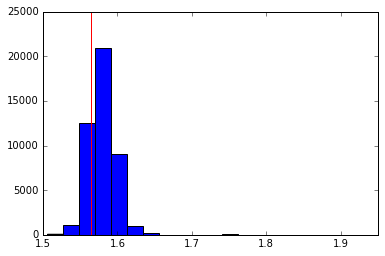

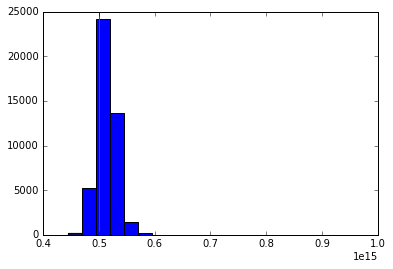

In [57]:
plt.hist(R200_fitted,bins=20)
plt.axvline(R200_true.value, color='r')
plt.show()
plt.hist(M200_fitted,bins=20)
plt.axvline(M200_true.value, color='r')
plt.show()

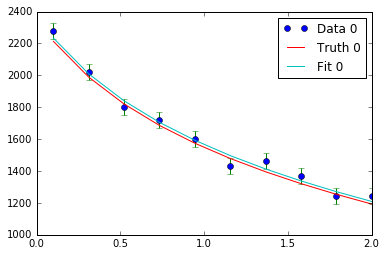

In [62]:
M200_fitted_50 = np.repeat(M200_fitted_50,len(z))
for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r_truth,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))
r_fitted,fitted = v_esc_NFW_M200(xdata,z,M200_fitted_50,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],fitted[i],'-', label = 'Fit '+ str(i))
plt.legend()

In [141]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

In [142]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [143]:
def lnprior(theta):
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    if not(0.05 < p_Omega_M < 0.5 and 0.5 < p_little_h < 1.0):
          return -np.inf
    return 0.0

In [144]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_Omega_M = np.repeat(theta[0],(1))
    p_little_h = np.repeat(theta[1],(1))
    p_N = N
    p_num_clus = num_clus
    p_cosmo_name = cosmo_name
    p_cosmo_params = [p_Omega_M,p_little_h]
    ymodel_fixed = lambda p_theta_array,p_cosmo_params,p_cosmo_name:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_cosmo_params,p_cosmo_name)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [145]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [146]:
ndim, nwalkers, nsteps = 2, 100, 1000
start_pos = [cosmo.Om0, cosmo.h]
p0 = np.transpose([np.random.uniform(0.05,0.5,size=nwalkers), np.random.uniform(0.5,0.95,size=nwalkers)])

In [147]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

State([[0.07471716 0.73729509]
 [0.29962885 0.64823438]
 [0.26042008 0.6599502 ]
 [0.15082609 0.69247345]
 [0.25924532 0.64999478]
 [0.14298469 0.71321213]
 [0.22883925 0.68508954]
 [0.29245982 0.63438562]
 [0.08845567 0.74131777]
 [0.06968998 0.76398312]
 [0.185368   0.69822559]
 [0.26422614 0.64920253]
 [0.25084391 0.66959859]
 [0.15425414 0.72398799]
 [0.14619928 0.72660441]
 [0.08914215 0.75776342]
 [0.06076477 0.76821797]
 [0.10573757 0.72716783]
 [0.22166689 0.66799702]
 [0.14966257 0.7195113 ]
 [0.06100889 0.75466256]
 [0.22390725 0.6858272 ]
 [0.18455103 0.67714547]
 [0.19334812 0.70966642]
 [0.05150967 0.75850795]
 [0.12897376 0.71097491]
 [0.11633157 0.72077399]
 [0.16250086 0.70641213]
 [0.3759974  0.60266175]
 [0.30809052 0.64994763]
 [0.25013539 0.64902284]
 [0.10993225 0.69910846]
 [0.08934678 0.76804004]
 [0.38603509 0.59792146]
 [0.06960728 0.74291096]
 [0.1692665  0.71006044]
 [0.14894359 0.72502605]
 [0.1265005  0.72347069]
 [0.0984034  0.73549573]
 [0.11538126 0.7137

(100, 1000, 2)


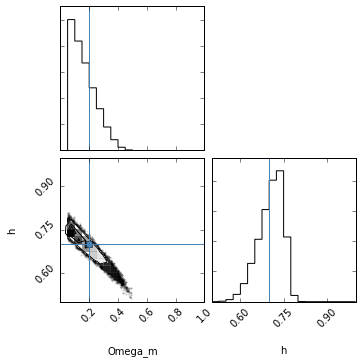

67
median(Omega_M) =  0.14968615996034176 +/- 0.09343144430179104 0.06992191821044191
median(h) =  0.7106856059458077 +/- 0.03533848781172211 0.051390616098823005
Truth:  0.2 0.7


In [148]:
burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 2))
print np.shape(sampler.chain)
#truths = [rho_s, r_s, M200.value],
#fig = corner.corner(samples[:,:], labels=["Omega_m", "h","M200", "z"], range=[(0,1), (0.5,1.0), (1e14,2e15), (0.09,1.1)])
fig = corner.corner(samples[:,:], labels=["Omega_m", "h"], truths = [cosmo.Om0, cosmo.h], range=[(0,1), (0.5,1.0)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
Omega_M_fit =  np.percentile(sampler.chain[:,:,0],percentile_array)
h_fit =  np.percentile(sampler.chain[:,:,1],percentile_array)
Omega_M_fit_50 =  np.percentile(sampler.chain[:,:,0],50)
h_fit_50 = np.percentile(sampler.chain[:,:,1],50)
Omega_M_fit_33 =  np.percentile(sampler.chain[:,:,0],33-16.5)
h_fit_33 = np.percentile(sampler.chain[:,:,1],33-16.5)
Omega_M_fit_67 =  np.percentile(sampler.chain[:,:,0],67+13.5)
h_fit_67 = np.percentile(sampler.chain[:,:,1],67+16.5)
print 'median(Omega_M) = ', Omega_M_fit_50, '+/-', Omega_M_fit_67-Omega_M_fit_50, Omega_M_fit_50-Omega_M_fit_33
print 'median(h) = ', h_fit_50, '+/-', h_fit_67-h_fit_50, h_fit_50-h_fit_33
print 'Truth: ', cosmo.Om0, cosmo.h\

In [149]:
burn = 200
Omega_m_fitted = sampler.chain[:,burn:,0].flatten()
h_fitted = sampler.chain[:,burn:,1].flatten()
rand_vec = np.random.uniform(1,len(Omega_m_fitted),size=5000).astype(int)
slope, intercept, r_value, p_value, std_err = linregress(Omega_m_fitted,h_fitted)
print slope, intercept
print std_err

-0.48541303166790734 0.7841265489305297
0.0005496349632452656


[100]


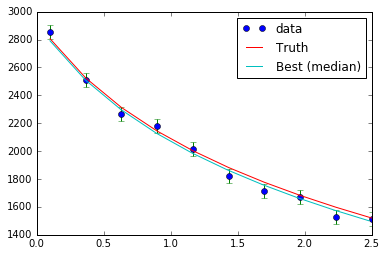

In [151]:
print N
plt.plot(radius_array,ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(radius_array,ydata[0],yerr=ydata_err[0], linestyle='None')
r_truth,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
plt.plot(r_truth[0], truth[0], '-', label = 'Truth')
r_fit,fit = v_esc_NFW_M200(xdata,z,M200_use,N,[Omega_M_fit_50,h_fit_50,], cosmo.name,num_clus)
plt.plot(r_fit[0], fit[0], '-', label = 'Best (median)')
plt.legend()

In [ ]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

In [ ]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [ ]:
def lnprior(theta):
    p_qH2 = theta[0]
    if not(-10000 < p_qH2 < 0):
          return -np.inf
    return 0.0

In [ ]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_qH2 = theta[0]
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    p_N = N
    p_num_clus = num_clus
    ymodel_fixed = lambda p_theta_array,p_qH2:v_esc_NFW_M200_qH2(p_theta_array,p_z,p_M200,p_N,p_qH2,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_qH2)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [ ]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
ndim, nwalkers, nsteps = 1, 1000, 500
p0 = np.transpose([np.random.uniform(-10000,0,size=nwalkers)])

In [ ]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

In [ ]:
burn = 100
H_z = H_z_function(z,cosmo_params,cosmo.name).value
q_z= q_z_function(z,cosmo_params,cosmo.name)
print H_z**2.0*q_z
samples = sampler.chain[:, burn:,0:].reshape((-1, 1))
print np.shape(sampler.chain), np.shape(samples)
fig = corner.corner(samples, labels=["qH2"], truths= [(H_z**2.0*q_z)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
qH2_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
qH2_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
qH2_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
qH2_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print 'median(qH2) = ', qH2_fit_50, '+/-', qH2_fit_67-qH2_fit_50, qH2_fit_50-qH2_fit_33
sigma_qH2_fit = (qH2_fit_67-qH2_fit_50 + qH2_fit_50-qH2_fit_33)/2.0
H_z = H_z_function(z,cosmo_params,cosmo.name).value
q_z= q_z_function(z,cosmo_params,cosmo.name)
print 'truth = ', H_z**2.0*q_z

median(qH2) =  -3069.45861178048 +/- 882.6157628030587 1199.7382618174252 Om=0.2
median(qH2) =  -2740.3968208140213 +/- 794.0167158673407 1123.8039894959147 Om = 0.1
median(qH2) =  -3392.601505853366 +/- 949.7394756548924 1276.6696775446298 Om = 0.3

In [ ]:
print r
r,ydata = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,cosmo_params, cosmo.name,num_clus)
plt.plot(r[0],ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(r[0],ydata[0],yerr=ydata_err[0], linestyle='None')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,cosmo_params, cosmo.name,num_clus)
plt.plot(r[0], truth[0], '-', label = 'Truth')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,qH2_fit_50, cosmo_params,cosmo.name,num_clus)
plt.plot(r[0], truth[0], '-', label = 'Best (median)')
plt.legend()

In [ ]:
burn = 100
qH2_fitted = sampler.chain[:,burn:,0].flatten()
rand_vec = np.random.uniform(1,len(qH2_fitted),size=1000).astype(int)
for i in range(1000):
    r,fitted = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,qH2_fitted[rand_vec[i]],[cosmo.Om0,cosmo.h],cosmo.name, num_clus)
    plt.plot(r[0], fitted[0],'grey',lw=0.1)
plt.plot(r[0],ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(r[0],ydata[0],yerr=ydata_err[0], linestyle='None')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,[cosmo.Om0,cosmo.h], cosmo.name, num_clus)
plt.plot(r[0], truth[0], '-', label = 'Truth')
plt.show()

In [ ]:
print qH2_fit_50/(70.0**2.0),qH2_fit_33/(70.0**2.0), qH2_fit_67/(70.0**2.0), H_z**2.0*q_z/(H_z**2.0)

In [ ]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)
z = np.array((0.05))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(5e14*u.solMass,len(z))
M200_use = np.repeat(5e14,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

In [ ]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms
for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [ ]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.arange(0.05,0.35,0.01)
num_clus = len(z)
print num_clus
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(150,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

In [ ]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [ ]:
def lnprior(theta):
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    if not(0.05 < p_Omega_M < 0.5 and 0.5 < p_little_h < 1.0):
          return -np.inf
    return 0.0

In [ ]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    p_N = N
    p_num_clus = num_clus
    p_cosmo_name = cosmo_name
    p_cosmo_params = [p_Omega_M,p_little_h]
    ymodel_fixed = lambda p_theta_array,p_cosmo_params,p_cosmo_name:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_cosmo_params,p_cosmo_name)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [ ]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
ndim, nwalkers, nsteps = 2, 100, 1000
start_pos = [cosmo.Om0, cosmo.h]
p0 = np.transpose([np.random.uniform(0.05,0.5,size=nwalkers), np.random.uniform(0.5,0.95,size=nwalkers)])

In [ ]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

In [ ]:
burn = 400
samples = sampler.chain[:, burn:, :].reshape((-1, 2))
print np.shape(sampler.chain)
#truths = [rho_s, r_s, M200.value],
#fig = corner.corner(samples[:,:], labels=["Omega_m", "h","M200", "z"], range=[(0,1), (0.5,1.0), (1e14,2e15), (0.09,1.1)])
fig = corner.corner(samples[:,:], labels=["Omega_m", "h"], truths = [cosmo.Om0, cosmo.h], range=[(0,0.4), (0.6,0.8)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
Omega_M_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
h_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
Omega_M_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
h_fit_50 = np.percentile(sampler.chain[:,burn:,1],50)
Omega_M_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
h_fit_33 = np.percentile(sampler.chain[:,burn:,1],33-16.5)
Omega_M_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+13.5)
h_fit_67 = np.percentile(sampler.chain[:,burn:,1],67+16.5)
print 'median(Omega_M) = ', Omega_M_fit_50, '+/-', Omega_M_fit_67-Omega_M_fit_50, Omega_M_fit_50-Omega_M_fit_33
print 'median(h) = ', h_fit_50, '+/-', h_fit_67-h_fit_50, h_fit_50-h_fit_33
print 'Truth: ', cosmo.Om0, cosmo.h

In [ ]:
median(Omega_M) =  0.16020498366050426 +/- 0.01405155129423255 0.01522627838347948
median(h) =  0.720601160633259 +/- 0.007356247709764618 0.007696122687491647
median(Omega_M) =  0.21746518705884668 +/- 0.013590641406457576 0.014819494484690166
median(h) =  0.6938228355105844 +/- 0.007340051381206525 0.007524068114170057
Truth:  0.2 0.7

In [ ]:
M200 = 1e15*u.solMass
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
cosmo_params = cosmology(cosmo)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /D_A(z,cosmo_params, cosmo.name)
real_error = []
real_mean = []
corr_coef = 0.2
for i in range(16):
    M200,R200,conc, rho_0, h,n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200, np.float(i)/20.0, z,cosmo_params, cosmo.name)
    M200_einasto = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0,h,n))[0]
    M200_einasto_p = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0+sigma_rho_0, h+corr_coef*sigma_h, n+sigma_n ))[0]
    M200_einasto_m = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0-sigma_rho_0, h-corr_coef*sigma_h, n-sigma_n ))[0]
    real_error =  np.append(real_error,((1-M200_einasto_m) + (M200_einasto_p-1))/(2*M200_einasto))
    real_mean =  np.append(real_mean,M200_einasto)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('Einasto Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15

M200,R200,conc,rho_0, h,n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200, 0.2, z,cosmo_params, cosmo.name)
print 'M200 = ', M200
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'n = ',n
print 'sigma n = ', sigma_n
print 'rho_0 = ',rho_0
print 'sigma_rho_0 = ', sigma_rho_0
print 'h = ', h
print 'sigma_h = ', corr_coef*h

In [ ]:
M200 = 5e14*u.solMass
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
cosmo_params = cosmology(cosmo)
radius_array = np.linspace(0.3,2.0,100).round(3)* u.Mpc #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /D_A(z,cosmo_params, cosmo.name)
real_error = []
real_mean = []
corr_coef = 0.85
for i in range(16):
    M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, np.float(i)/20.0, z,cosmo_params, cosmo.name)
    M200_nfws = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s, r_s))[0]
    M200_nfws_p = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s+sigma_rho_s,r_s+corr_coef*sigma_r_s))[0]
    M200_nfws_m = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s-sigma_rho_s,r_s-corr_coef*sigma_r_s))[0]
    real_error =  np.append(real_error,((1-M200_nfws_m) + (M200_nfws_p-1))/(2*M200_nfws))
    real_mean =  np.append(real_mean,M200_nfws)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('NFW Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

print 'M200 = ', M200/1e14
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'rho_s/1e14 = ' , rho_s/1e14
print 'sigma rho_s/1e14 = ' , sigma_rho_s/1e14
print 'r_s = ',r_s
print 'sigma r_s = ', sigma_r_s